In [1]:
require(openxlsx)
require(tidyverse)
require(ggrepel)
require(gridExtra)
require(missMDA)

Loading required package: openxlsx

Warning message:
"package 'openxlsx' was built under R version 4.2.2"
Loading required package: tidyverse

Warning message:
"package 'tidyverse' was built under R version 4.2.2"
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
Loading required package: ggrepel

Loading required package: gridExtra


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Loading required package: missMDA

Warning message:
"package 'missMDA' was built under R versi

### Input data

In [2]:
df_norm <- read.csv("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-归一化.csv")
df_stat <- read.csv("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-描述性统计.csv")

df_raw <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3.xlsx")
df_raw_anno <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3.xlsx", sheet = 2)

df_ykl <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-源库流和抗逆分类.xlsx")
df_ykl_anno <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-源库流和抗逆分类.xlsx", sheet = 2)

df_stress <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-源库流和抗逆分类.xlsx", sheet = 3)
df_stress_anno <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V3-源库流和抗逆分类.xlsx", sheet = 4)

In [3]:
# Phenotype summary
# pheno_sum <- read.xlsx("../phenotype_data/Previous_version/Pheno_summary.xlsx")

In [3]:
# Traits needs to be removed in V4
remove <- read.xlsx("../phenotype_data/383农艺性状汇总表V3/383农艺性状汇总表V4-updated-20221202.xlsx", sheet = 3)
rm_traits <- remove$Remove_Trait

update_data <- function(df, rm_traits){
    df <- df %>% select(setdiff(colnames(.) ,rm_traits))
    return(df)
}
df_raw <- update_data(df_raw, rm_traits)
df_norm <- update_data(df_norm, rm_traits)
df_ykl <- update_data(df_ykl, rm_traits)
df_stress <- update_data(df_stress, rm_traits)

df_raw_anno <- df_raw_anno %>% mutate(性状分类1 = gsub(' ', '', 性状分类1))

### Summary
- 383 lines
- 3986 phenotype
    - 去除实验重复后有 1468 个性状。
- 需要每个性状 `种植年份` `种植地点` `有无重复` 的信息：

#### 性状 - 年份 - 地点

In [203]:
# No. of unique trait
df_stat %>% .$Traits %>% toupper() %>% .[!grepl("R1|R2|R3", .)] %>% length

[1] 1468

##### 性状分类 数量

In [37]:
# generate data
tmp <- df_raw_anno %>% 
    setNames(c('Traits', 'Annotation', 'Trait_Class')) %>% 
#     mutate(Trait_Class = gsub(' ', '', Trait_Class)) %>% 
    group_by(Trait_Class) %>% 
    summarise_at(vars(Traits), list(length))

tmp_order <- tmp %>% arrange(desc(Traits)) %>% .$Trait_Class
tmp <- tmp %>% mutate(Trait_Class = factor(Trait_Class, levels = tmp_order))

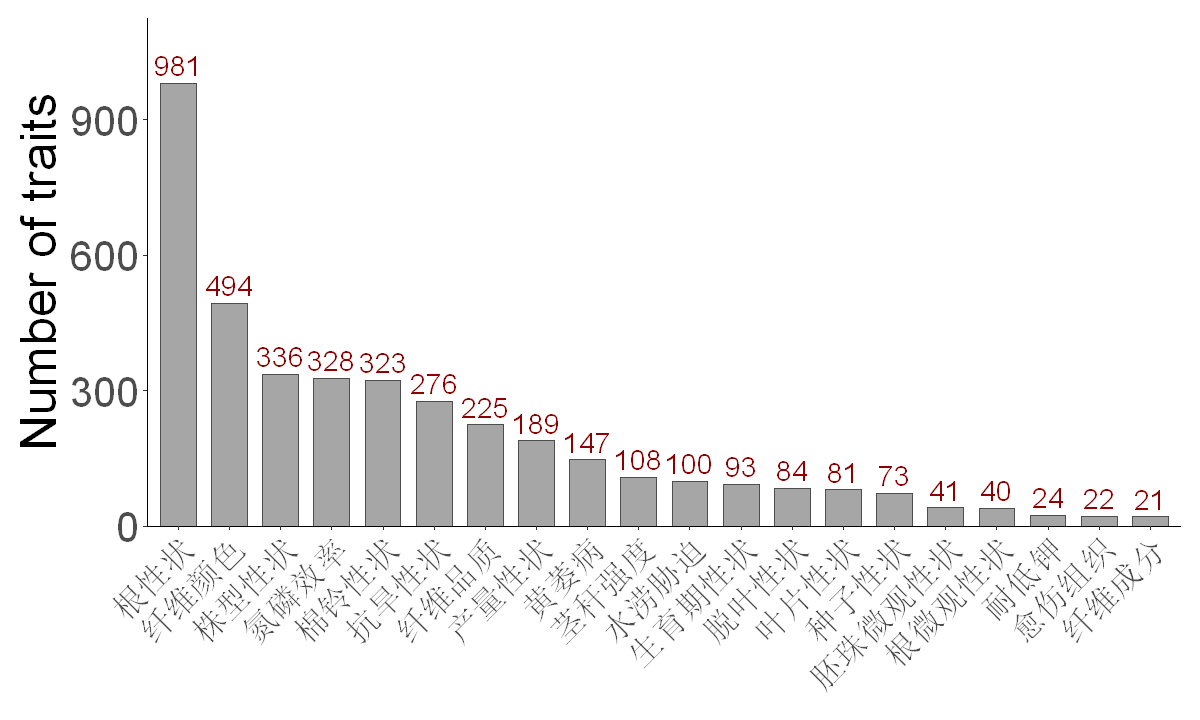

In [39]:
# plot
options(repr.plot.width = 10, repr.plot.height = 6)

tmp %>% 
    ggplot(., aes(x = Trait_Class, y = Traits)) + 
    geom_col(width = 0.7, alpha = 0.5, color = "grey30", fill = "grey30") +
    geom_text(aes(x = Trait_Class, y = Traits + 40, label = Traits), size=6, color = "darkred") +
    theme_classic()+
    ylab("Number of traits") +
    scale_y_continuous(expand = expansion(mult = c(0, 0.1)))+
    theme(axis.text.y = element_text(size = 25),
          axis.text.x = element_text(size = 20, angle = 45, hjust=1, vjust=1),
          axis.title = element_text(size = 30),
          axis.title.x  = element_blank(),
          legend.text = element_text(size = 25),
          legend.title = element_text(size = 30),
          plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

##### 源库流

Loading required package: UpSetR

Warning message:
"package 'UpSetR' was built under R version 4.2.2"


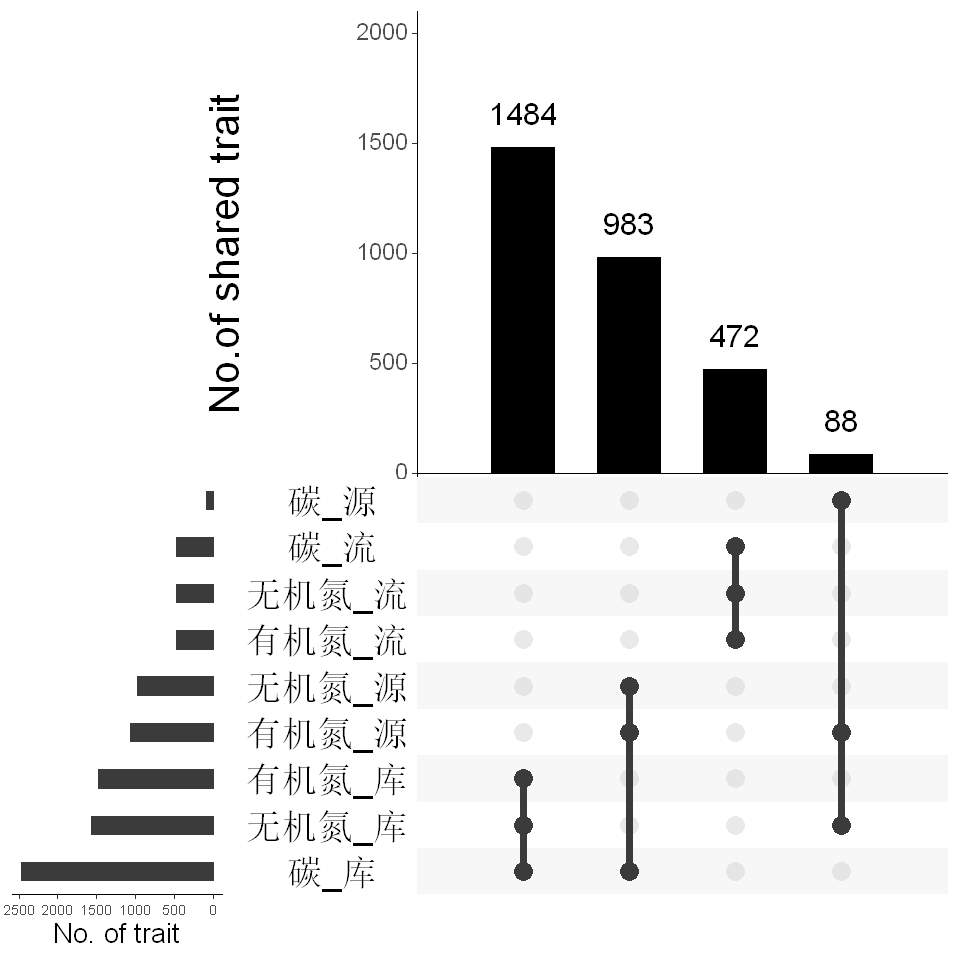

In [40]:
# Upset plot
require(UpSetR)

input_list <- list(
    碳_库 = df_ykl_anno %>% subset(碳 == '库1') %>% .$性状, 
    无机氮_库 = df_ykl_anno %>% subset(无机氮 == '库2') %>% .$性状,
    有机氮_库 = df_ykl_anno %>% subset(有机氮 == '库3') %>% .$性状,
    碳_源 = df_ykl_anno %>% subset(碳 == '源1') %>% .$性状,
    无机氮_源 = df_ykl_anno %>% subset(无机氮 == '源2') %>% .$性状,
    有机氮_源 = df_ykl_anno %>% subset(有机氮 == '源3') %>% .$性状,
    碳_流 = df_ykl_anno %>% subset(碳 == '流') %>% .$性状,
    无机氮_流 = df_ykl_anno %>% subset(无机氮 == '流') %>% .$性状,
    有机氮_流 = df_ykl_anno %>% subset(有机氮 == '流') %>% .$性状)

options(repr.plot.width = 8, repr.plot.height = 8)
upset(fromList(input_list), 
      order.by = c("freq", "degree"), 
      decreasing = c(TRUE,TRUE),
      nsets = 9,
      nintersects = NA,
      point.size = 5, 
      line.size = 2, 
      mb.ratio = c(0.5, 0.5),
      mainbar.y.label = "No.of shared trait", 
      mainbar.y.max = 2000,
      sets.x.label = "No. of trait", 
      text.scale = c(3, 2, 2, 1.2, 3, 3),
      main.bar.color = "black")

In [41]:
input_list %>% lapply(length) %>% as.data.frame()

碳_库,无机氮_库,有机氮_库,碳_源,无机氮_源,有机氮_源,碳_流,无机氮_流,有机氮_流
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2467,1572,1484,88,983,1071,472,472,472


Loading required package: ggsankey



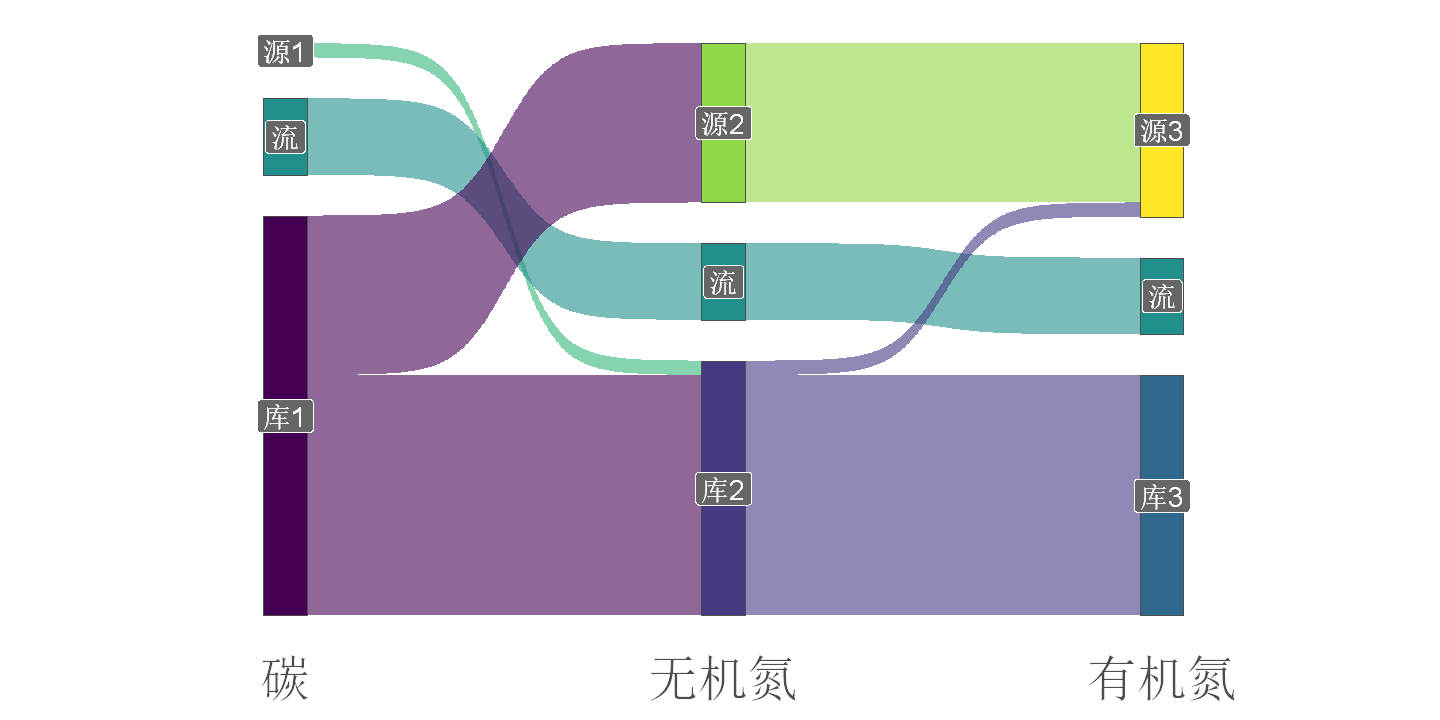

In [42]:
# sankey plot
require(ggsankey)
tmp <- df_ykl_anno %>% make_long(碳, 无机氮, 有机氮)

options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(tmp, aes(x = x, 
               next_x = next_x, 
               node = node, 
               next_node = next_node,
               fill = factor(node),
               label = node)) +
  geom_sankey(flow.alpha = .6,
              node.color = "gray30")+
  geom_sankey_label(size = 6, color = "white", fill = "gray40") +
  scale_fill_viridis_d() +
  labs(x = NULL) +
  theme_sankey(base_size = 18) +
  theme(legend.position = "none", 
        axis.text.x = element_text(size = 30)) 

###### 源库流 与 性状分类的对应关系

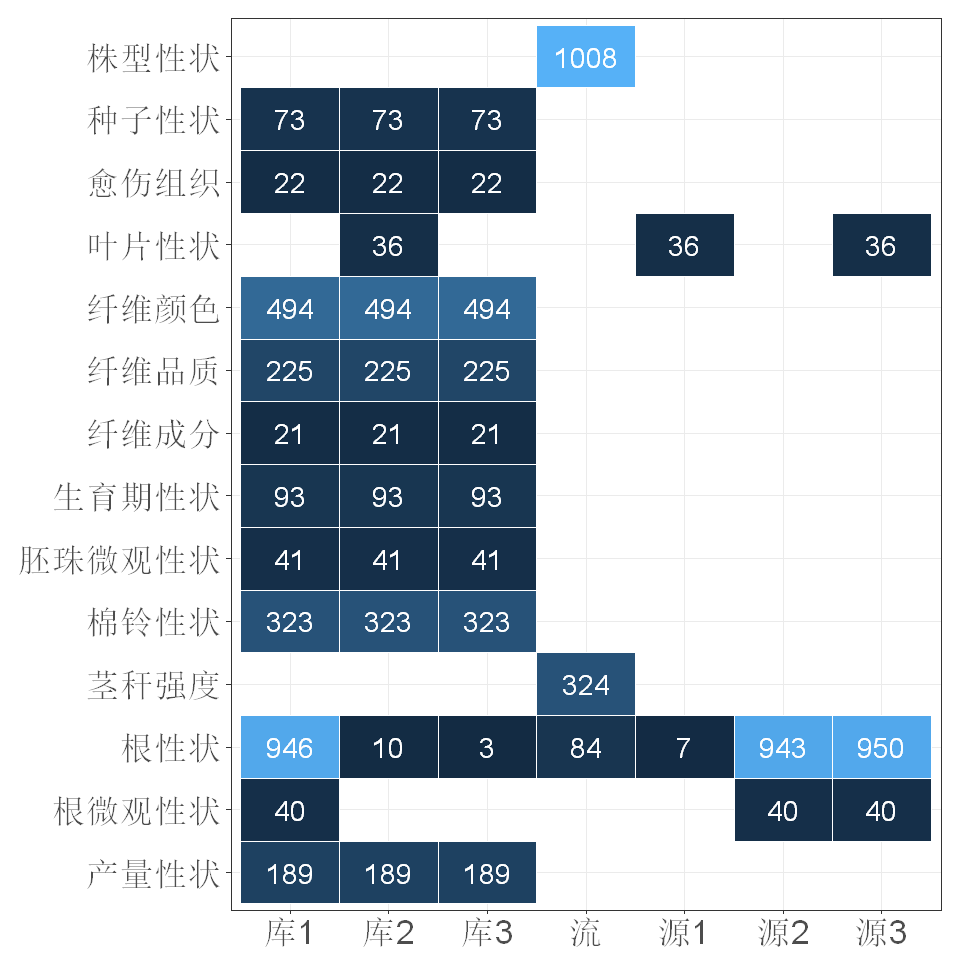

In [43]:
options(repr.plot.width = 8, repr.plot.height = 8)

df_ykl_anno %>% 
merge(df_raw_anno[c('性状', '性状分类1')]) %>% 
gather(element, type, 4:6) %>% 
group_by(type, 性状分类1) %>% 
summarise_at(vars(性状), list(length)) %>% 
ggplot(., aes(type, 性状分类1)) + 
  geom_tile(aes(fill = 性状),colour = "white") +
  geom_text(aes(label = 性状), color = "white", size = 6) +
#   scale_fill_gradient(low = "yellow", high = "red") +
#   scale_fill_gradientn(colors = hcl.colors(20, "RdYlGn")) +
  ylab(NULL) +
  theme_bw() +
    theme(axis.text.y = element_text(size = 20),
          axis.text.x = element_text(size = 20),
          axis.title = element_text(size = 30),
          axis.title.x  = element_blank(),
          legend.position = 'none',
          legend.text = element_text(size = 20),
          legend.title = element_text(size = 20),
          plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

##### 抗逆抗病性状

In [44]:
# input
tmp <- df_stress_anno %>% 
    setNames(c('Traits', 'Annotation', 'Trait_Class')) %>% 
    group_by(Trait_Class) %>% 
    summarise_at(vars(Traits), list(length))

tmp_order <- tmp %>% arrange(desc(Traits)) %>% .$Trait_Class
tmp <- tmp %>% mutate(Trait_Class = factor(Trait_Class, levels = tmp_order))

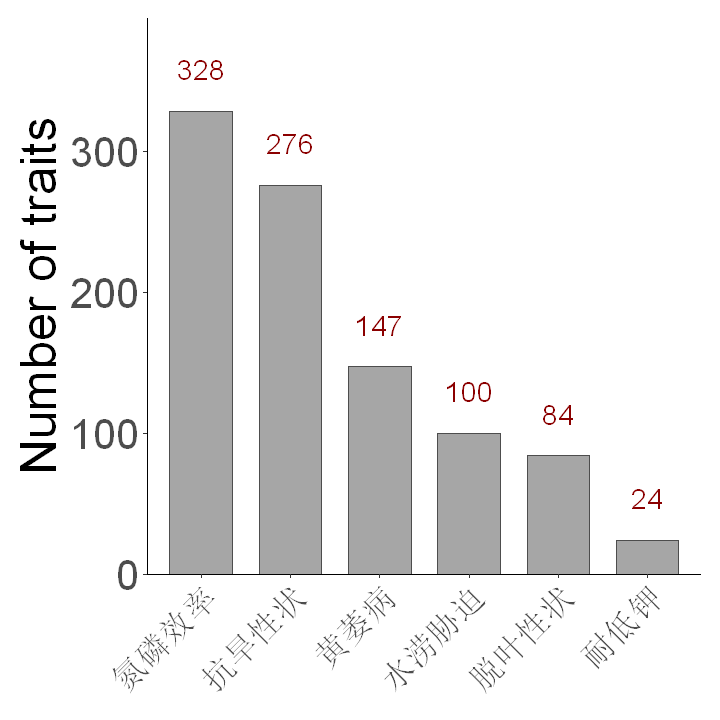

In [45]:
# plot
options(repr.plot.width = 6, repr.plot.height = 6)

tmp %>% 
    ggplot(., aes(x = Trait_Class, y = Traits)) + 
    geom_col(width = 0.7, alpha = 0.5, color = "grey30", fill = "grey30") +
    geom_text(aes(x = Trait_Class, y = Traits + 30, label = Traits), size=6, color = "darkred") +
    theme_classic()+
    ylab("Number of traits") +
    scale_y_continuous(expand = expansion(mult = c(0, 0.1)))+
    theme(axis.text.y = element_text(size = 25),
          axis.text.x = element_text(size = 20, angle = 45, hjust=1, vjust=1),
          axis.title = element_text(size = 30),
          axis.title.x  = element_blank(),
          legend.text = element_text(size = 25),
          legend.title = element_text(size = 30),
          plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

In [11]:
?writeLines

### PCA results
#### PCA of all genotyps

In [5]:
df_raw %>% dim

[1]  383 3971

In [6]:
# generate PCA data
pca_1 <- df_raw %>% 
    remove_rownames() %>% 
    column_to_rownames('ID') %>%
    sapply(., as.numeric) %>% 
    cbind(df_raw['ID'], .) %>% 
    column_to_rownames('ID') %>%
    imputePCA(., scale = F, method = "Regularized") %>% 
    .$completeObs %>% 
    prcomp(., center = T, scale. = T)    

Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"


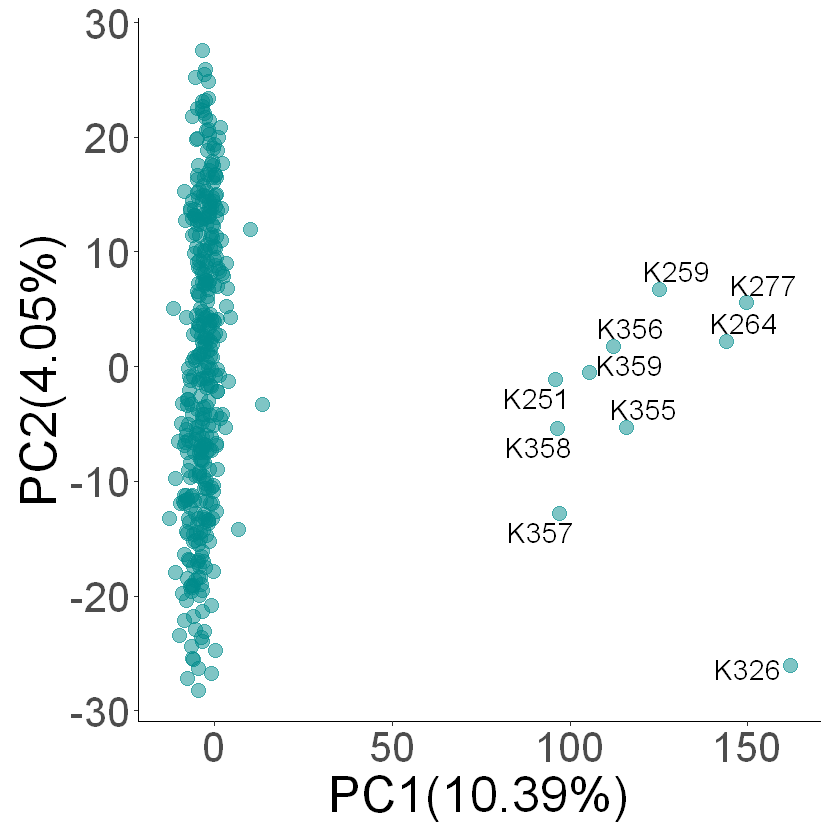

In [7]:
# PCA plot
pca_df <- as.data.frame(pca_1$x)
summ <- summary(pca_1)
xlab <- paste0("PC1(", round(summ$importance[2, 1] * 100, 2), "%)")
ylab <- paste0("PC2(", round(summ$importance[2, 2] * 100, 2), "%)")

df_label <- pca_df %>% subset(PC1 > 50) %>%  .[c('PC1', 'PC2')] 

p.pca <- ggplot(data = pca_df, aes(x = PC1,y = PC2))+
  geom_point(color = 'cyan4', alpha = 0.5, size = 4)+
  geom_text_repel(data = df_label, 
                  aes(PC1, PC2, label=rownames(df_label)),
                  size = 6)+
  labs(x = xlab,y = ylab)+
  guides(fill = "none")+
  theme_classic()+
  theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 25),
        axis.title = element_text(size = 30),
        legend.text = element_text(size = 25),
        legend.title = element_text(size = 30),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

p.pca

In [34]:
# the average traits value of the ten outliers 
tmp <- df_raw %>% 
    gather(trait, value, 2:3971) %>% 
    mutate(Group = ifelse(ID %in% rownames(df_label), 'Outlier', 'Normal')) %>% 
    mutate(value = as.numeric(value)) %>% 
    na.omit() %>% 
    group_by(Group, trait) %>% 
    summarise_at(vars(value), list(mean)) %>% 
    mutate(log10_value = log10(value))

Warning message in mask$eval_all_mutate(quo):
"NAs introduced by coercion"
Warning message in mask$eval_all_mutate(quo):
"NaNs produced"
Warning message in mask$eval_all_mutate(quo):
"NaNs produced"


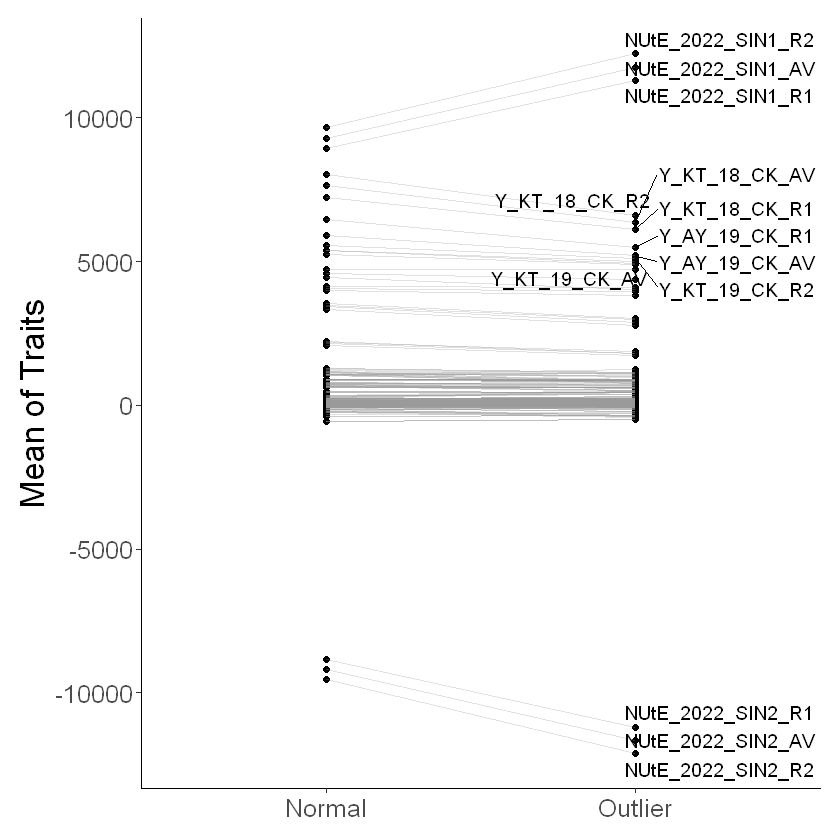

In [60]:
# plot 1
options(repr.plot.width = 7, repr.plot.height = 7)
tmp_label <- tmp %>% subset(value > 5000 | value < -5000) %>% subset(Group == 'Outlier')

ggplot(tmp, aes(Group, value)) +
    geom_point() +
    geom_line(aes(group=trait), color="grey60", alpha=0.3) +
    geom_text_repel(data = tmp_label, 
                    aes(Group, value, label=trait), nudge_x = 3, size = 4) +
    ylab('Mean of Traits') +
    xlab(NULL) +
    theme_classic() +
    theme_classic()+
    theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
#         legend.text = element_text(size = 25),
#         legend.title = element_text(size = 30),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

Warning message:
"Removed 254 rows containing missing values (geom_point)."
Warning message:
"Removed 254 row(s) containing missing values (geom_path)."


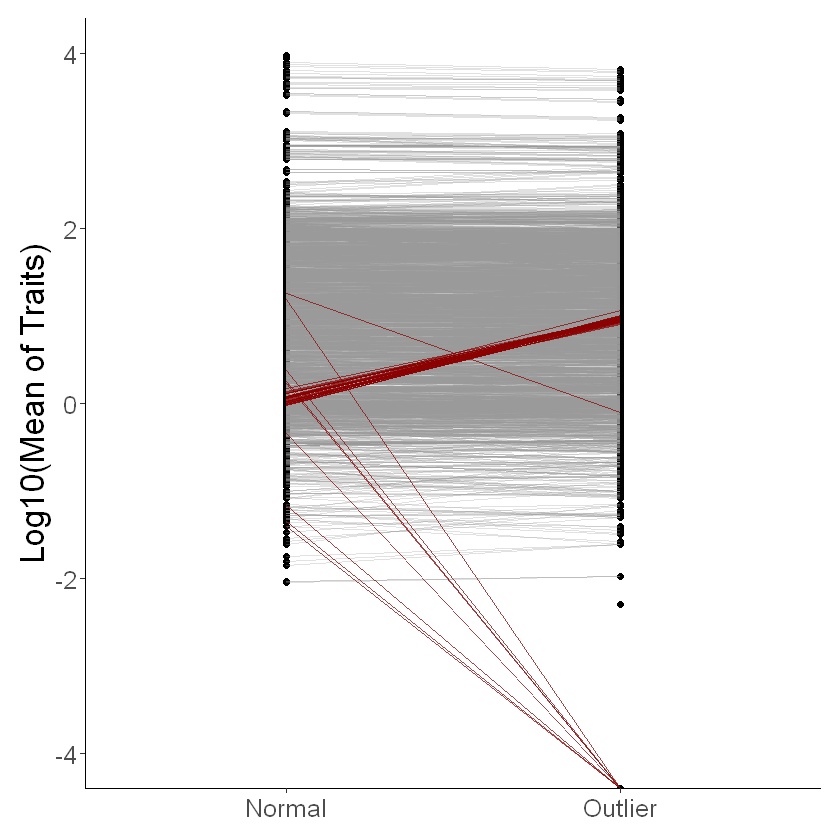

In [106]:
# plot 2
options(repr.plot.width = 7, repr.plot.height = 7)

tmp_log_diff <- tmp %>% select(-value) %>% spread(Group, log10_value) %>% subset(abs(Normal - Outlier) > 0.8)
tmp_label <- tmp %>% subset(trait %in% tmp_log_diff$trait)

ggplot(tmp, aes(Group, log10_value)) +
    geom_point() +
    geom_line(aes(group=trait), color="grey60", alpha=0.3) +
    geom_line(data = tmp_label, aes(group=trait), color="darkred", alpha=0.7) +
#     geom_text_repel(data = tmp_label %>% subset(Group == 'Normal'), 
#                     aes(Group, value, label=trait), nudge_x = -4, nudge_y = 0, size = 4) +
    scale_y_continuous(limits = c(-4, 4)) +
    ylab('Log10(Mean of Traits)') +
    xlab(NULL) +
    theme_classic() +
    theme_classic()+
    theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
#         legend.text = element_text(size = 25),
#         legend.title = element_text(size = 30),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

In [108]:
df_raw_anno

,性状,注释,性状分类1
,<chr>,<chr>,<chr>
1,FE_AL_18_CK_R1,对照小区断裂伸长率%_R1,纤维品质
2,FE_AL_18_CK_R2,对照小区断裂伸长率%_R2,纤维品质
3,FE_AL_18_CK_AV,对照小区断裂伸长率%_AV,纤维品质
4,FE_AL_19_CK_R1,对照小区伸长率(%)R1,纤维品质
5,FE_AL_19_CK_R2,对照小区伸长率(%)R2,纤维品质
6,FE_AL_19_CK_AV,对照小区伸长率(%)AV,纤维品质
7,FE_AY_18_R1,断裂伸长率%_R1,纤维品质
8,FE_AY_18_R2,断裂伸长率%_R2,纤维品质
9,FE_AY_18_AV,断裂伸长率%_AV,纤维品质


In [109]:
df_raw_anno %>% subset(性状 %in% unique(tmp_label$trait))

,性状,注释,性状分类1
,<chr>,<chr>,<chr>
238,aa_KT_19_R1,奎屯19年色度指数R1,纤维颜色
277,a1_KT_19_R1,奎屯19年色度指数R1,纤维颜色
319,aa_AY_19_R1,安阳19年色度指数R1,纤维颜色
320,aa_AY_19_R2,安阳19年色度指数R2,纤维颜色
321,aa_AY_19_AV,安阳19年色度指数AV,纤维颜色
331,a_AY_19_R1,安阳19年亨特色品指数R1,纤维颜色
332,a_AY_19_R2,安阳19年亨特色品指数R2,纤维颜色
333,a_AY_19_AV,安阳19年亨特色品指数AV,纤维颜色
358,a1_AY_19_R1,安阳19年色度指数R1,纤维颜色


Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"


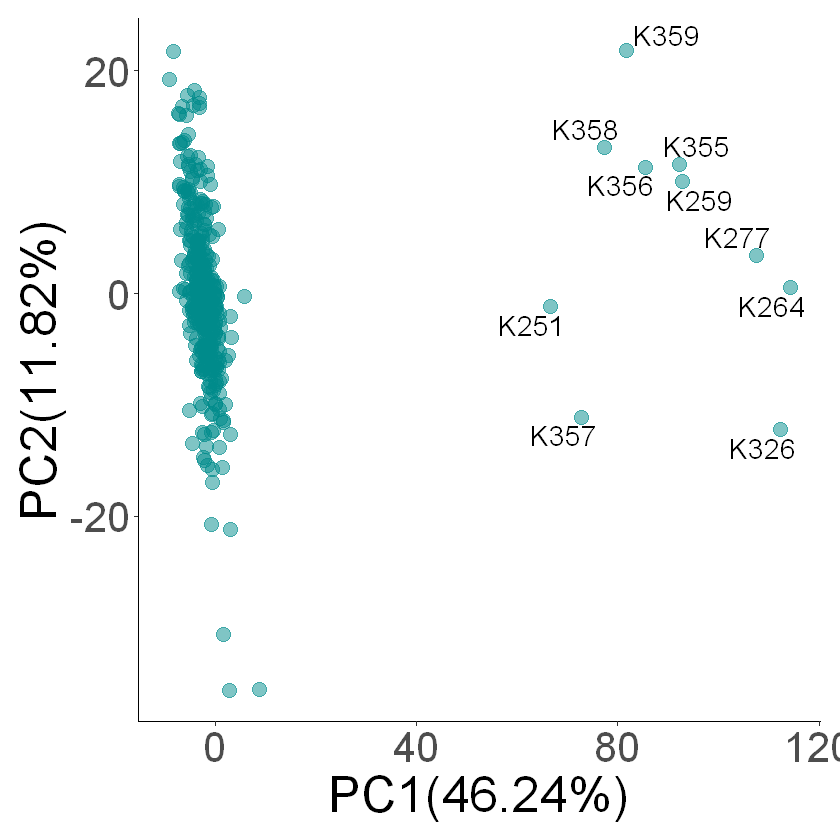

In [44]:
# pca with the first 500 cols 
pca_1 <- df_raw %>% 
    .[, 1:500] %>% 
    remove_rownames() %>% 
    column_to_rownames('ID') %>%
    sapply(., as.numeric) %>% 
    cbind(df_raw['ID'], .) %>% 
    column_to_rownames('ID') %>%
    imputePCA(., scale = F, method = "Regularized") %>% 
    .$completeObs %>% 
    prcomp(., center = T, scale. = T)    

pca_df <- as.data.frame(pca_1$x)
summ <- summary(pca_1)
xlab <- paste0("PC1(", round(summ$importance[2, 1] * 100, 2), "%)")
ylab <- paste0("PC2(", round(summ$importance[2, 2] * 100, 2), "%)")

df_label <- pca_df %>% subset(PC1 > 50) %>%  .[c('PC1', 'PC2')] 

p.pca <- ggplot(data = pca_df, aes(x = PC1,y = PC2))+
  geom_point(color = 'cyan4', alpha = 0.5, size = 4)+
  geom_text_repel(data = df_label, 
                  aes(PC1, PC2, label=rownames(df_label)),
                  size = 6)+
  labs(x = xlab,y = ylab)+
  guides(fill = "none")+
  theme_classic()+
  theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 25),
        axis.title = element_text(size = 30),
        legend.text = element_text(size = 25),
        legend.title = element_text(size = 30),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

p.pca

Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"


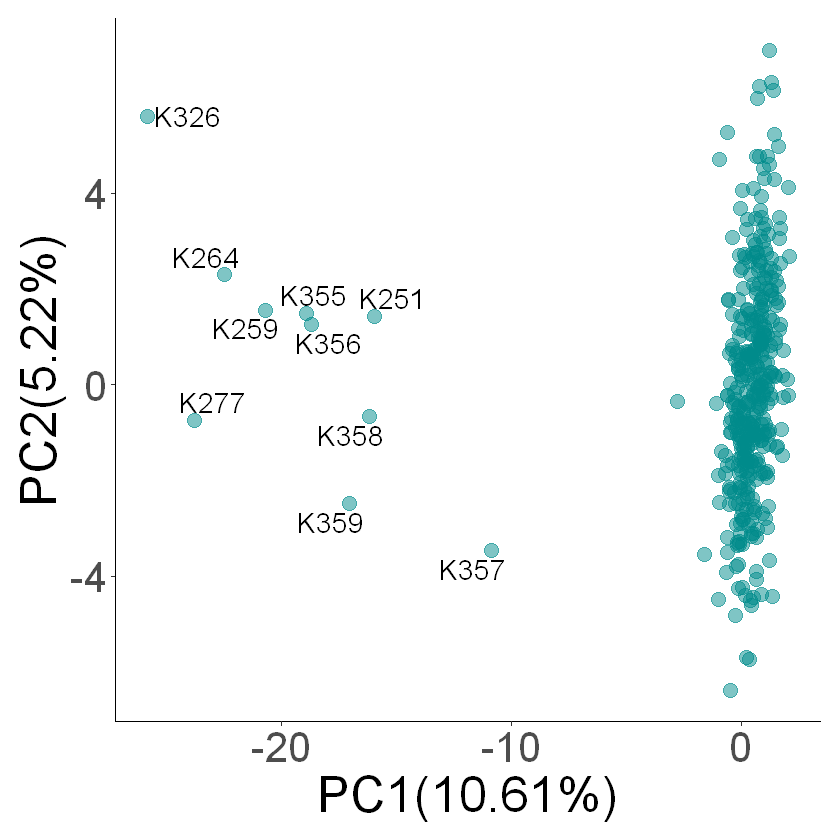

In [49]:
# pca with randomly selected 100 cols
set.seed(123)
pca_1 <- df_raw %>% 
    remove_rownames() %>% 
    column_to_rownames('ID') %>%
    sapply(., as.numeric) %>% 
    cbind(df_raw['ID'], .) %>% 
    column_to_rownames('ID') %>%
    .[sample(colnames(.), 100)] %>% 
    imputePCA(., scale = F, method = "Regularized") %>% 
    .$completeObs %>% 
    prcomp(., center = T, scale. = T)    

pca_df <- as.data.frame(pca_1$x)
summ <- summary(pca_1)
xlab <- paste0("PC1(", round(summ$importance[2, 1] * 100, 2), "%)")
ylab <- paste0("PC2(", round(summ$importance[2, 2] * 100, 2), "%)")

df_label <- pca_df %>% subset(PC1 < -10) %>%  .[c('PC1', 'PC2')] 

p.pca <- ggplot(data = pca_df, aes(x = PC1,y = PC2))+
  geom_point(color = 'cyan4', alpha = 0.5, size = 4)+
  geom_text_repel(data = df_label, 
                  aes(PC1, PC2, label=rownames(df_label)),
                  size = 6)+
  labs(x = xlab,y = ylab)+
  guides(fill = "none")+
  theme_classic()+
  theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 25),
        axis.title = element_text(size = 30),
        legend.text = element_text(size = 25),
        legend.title = element_text(size = 30),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

p.pca

#### PCA of all traits

In [50]:
# # imputation method: Regularized
# # options(warn = -1)

# pca_1 <- df_raw %>% 
#     remove_rownames() %>% 
#     column_to_rownames('ID') %>%
#     sapply(., as.numeric) %>%
#     t() %>% 
#     imputePCA(., scale = F, method = "Regularized") %>% 
#     .$completeObs %>% 
#     prcomp(., center = T, scale. = T)

Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"


In [51]:
# input the entire PCA result
# pca_df <- read.csv("../01.data _summary/all_traits_PCA_df.csv", row.names = 1)

In [52]:
pca_df <- as.data.frame(pca_1$x)
summ <- summary(pca_1)
xlab <- paste0("PC1(", round(summ$importance[2, 1] * 100, 2), "%)")
ylab <- paste0("PC2(", round(summ$importance[2, 2] * 100, 2), "%)")

df_label <- pca_df %>% subset(PC1 < -200 | PC1 > 80) %>%  .[c('PC1', 'PC2')]

write.csv(pca_df, "../01.data _summary/all_traits_PCA_df_V4Phenotype.csv")

##### _Some traits are very discrete! Remove then and do PCA again._

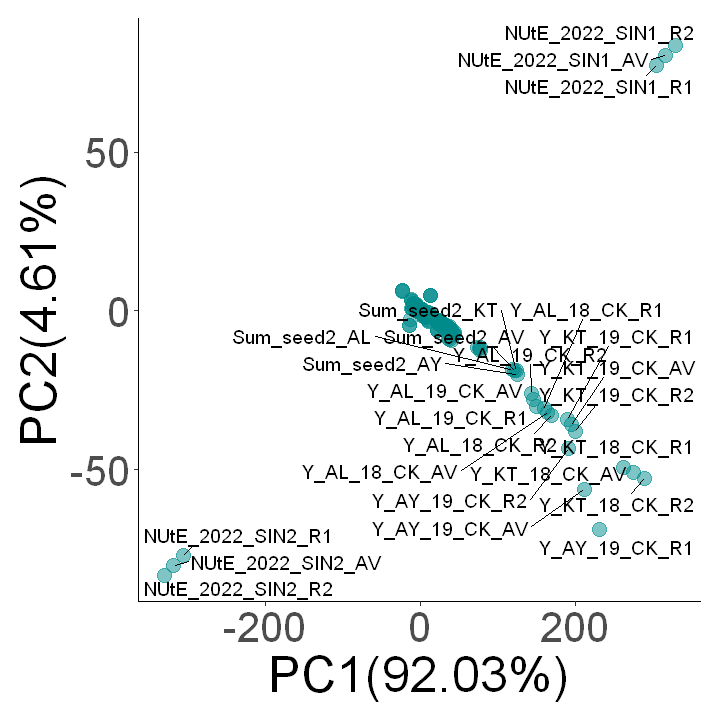

In [53]:
# PCA 1
options(repr.plot.width = 6, repr.plot.height = 6)

pca_df %>% 
    rownames_to_column("Trait_ID") %>% 
    merge(df_raw_anno[c(1, 3)] %>% setNames(c('Trait_ID', 'Trait_Class'))) %>% 
    ggplot(., aes(x = PC1,y = PC2))+
    geom_point(color = 'cyan4', alpha = 0.5, size = 4)+
    geom_text_repel(data = df_label, 
                      max.overlaps = 20,
                      aes(PC1, PC2, label=rownames(df_label)),
                      size = 4)+
    labs(x = xlab,y = ylab)+
    guides(fill = "none")+
    theme_classic()+
    theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 25),
        axis.title = element_text(size = 30),
        legend.text = element_text(size = 25),
        legend.title = element_text(size = 30),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

In [165]:
# The annotation of the discreted traits
df_label %>% rownames_to_column("性状") %>% merge(df_raw_anno, by = "性状", all.x=T)

性状,PC1,PC2,注释,性状分类1
<chr>,<dbl>,<dbl>,<chr>,<chr>
NUtE_2022_SIN1_AV,318.2148,80.63859,胁迫指数（LN/CK）NUtEAV,氮磷效率
NUtE_2022_SIN1_R1,305.7593,77.52263,胁迫指数（LN/CK）NUtER1,氮磷效率
NUtE_2022_SIN1_R2,330.6703,83.75454,胁迫指数（LN/CK）NUtER2,氮磷效率
NUtE_2022_SIN2_AV,-319.4751,-80.34447,胁迫指数（（CK-LN)/CK）NUtEAV,氮磷效率
NUtE_2022_SIN2_R1,-307.0196,-77.22851,胁迫指数（（CK-LN)/CK）NUtER1,氮磷效率
NUtE_2022_SIN2_R2,-331.9306,-83.46042,胁迫指数（（CK-LN)/CK）NUtER2,氮磷效率
Sum_seed2_AL,119.0377,-18.50240,每个种子突起总数（阿拉尔）椭球模型,胚珠微观性状
Sum_seed2_AV,122.3320,-18.89656,每个种子突起总数（三个点的平均数）椭球模型,胚珠微观性状
Sum_seed2_AY,126.0810,-20.05352,每个种子突起总数（安阳）椭球模型,胚珠微观性状


##### 性状分类1

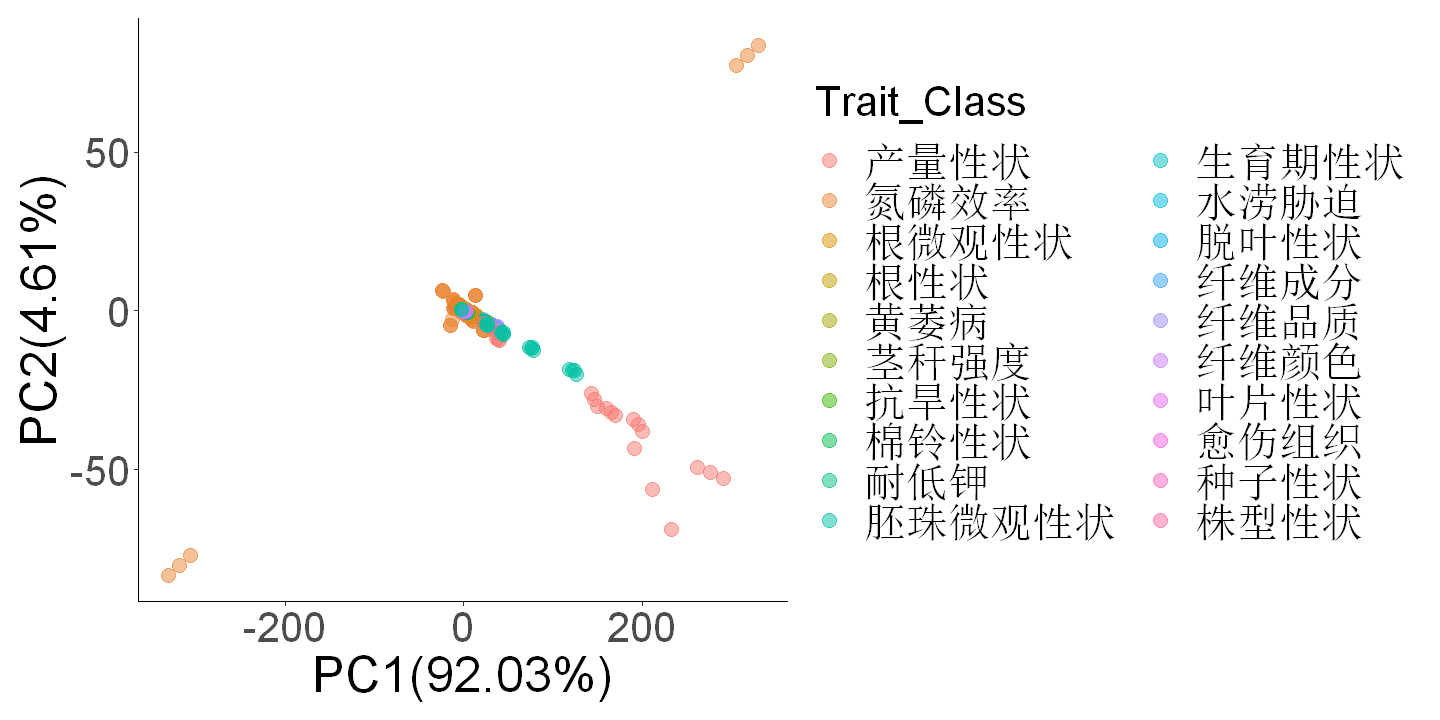

In [64]:
# PCA 性状类型
options(repr.plot.width = 12, repr.plot.height = 6)

pca_df %>% 
    rownames_to_column("Trait_ID") %>% 
    merge(df_raw_anno[c(1, 3)] %>% setNames(c('Trait_ID', 'Trait_Class'))) %>% 
    ggplot(., aes(x = PC1,y = PC2, color = Trait_Class))+
    geom_point(alpha = 0.5, size = 4)+
#     geom_text_repel(data = df_label, 
#                       max.overlaps = 20,
#                       aes(PC1, PC2, label=rownames(df_label)),
#                       size = 4)+
    labs(x = xlab,y = ylab)+
    guides(color = guide_legend(ncol = 2)) +
    theme_classic()+
    theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 25),
        axis.title = element_text(size = 30),
        legend.text = element_text(size = 25),
        legend.title = element_text(size = 25),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

###### 直接去掉 discrete 性状

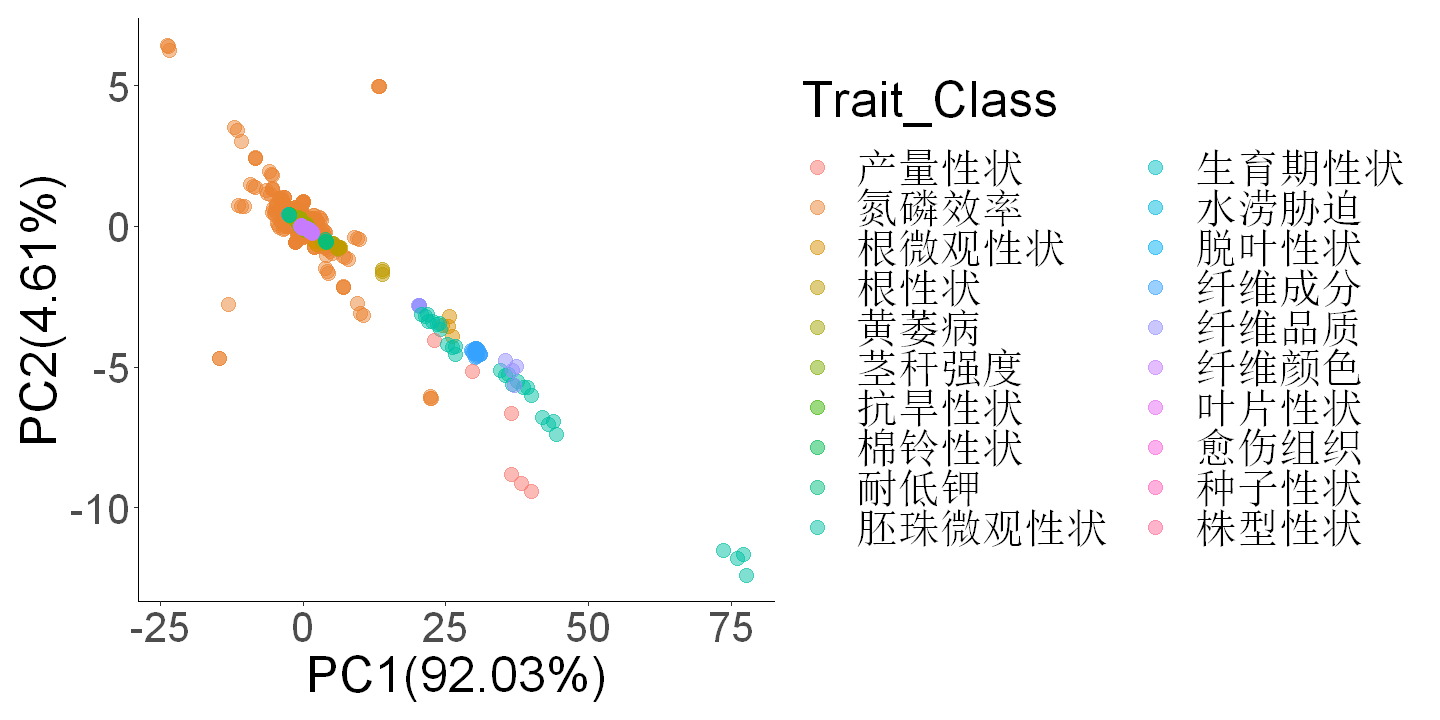

In [65]:
# PCA 直接去掉 discrete 性状
options(repr.plot.width = 12, repr.plot.height = 6)

pca_df %>% 
    rownames_to_column("Trait_ID") %>% 
    merge(df_raw_anno[c(1, 3)] %>% setNames(c('Trait_ID', 'Trait_Class'))) %>% 
    subset(!(Trait_ID %in% rownames(df_label))) %>% 
    ggplot(., aes(x = PC1,y = PC2, color = Trait_Class))+
    geom_point(alpha = 0.5, size = 4)+
#     geom_text_repel(data = df_label, 
#                       max.overlaps = 20,
#                       aes(PC1, PC2, label=rownames(df_label)),
#                       size = 4)+
    labs(x = xlab,y = ylab)+
    guides(color = guide_legend(ncol = 2)) +
    theme_classic()+
    theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 25),
        axis.title = element_text(size = 30),
        legend.text = element_text(size = 25),
        legend.title = element_text(size = 30),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

###### Remove discrete traits and redo PCA

In [409]:
pca_1 <- df_raw %>% 
    select(-rownames(df_label)) %>% 
    remove_rownames() %>% 
    column_to_rownames('ID') %>%
    sapply(., as.numeric) %>%
    t() %>% 
    imputePCA(., scale = F, method = "Regularized") %>% 
    .$completeObs %>% 
    prcomp(., center = T, scale. = T)

Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"


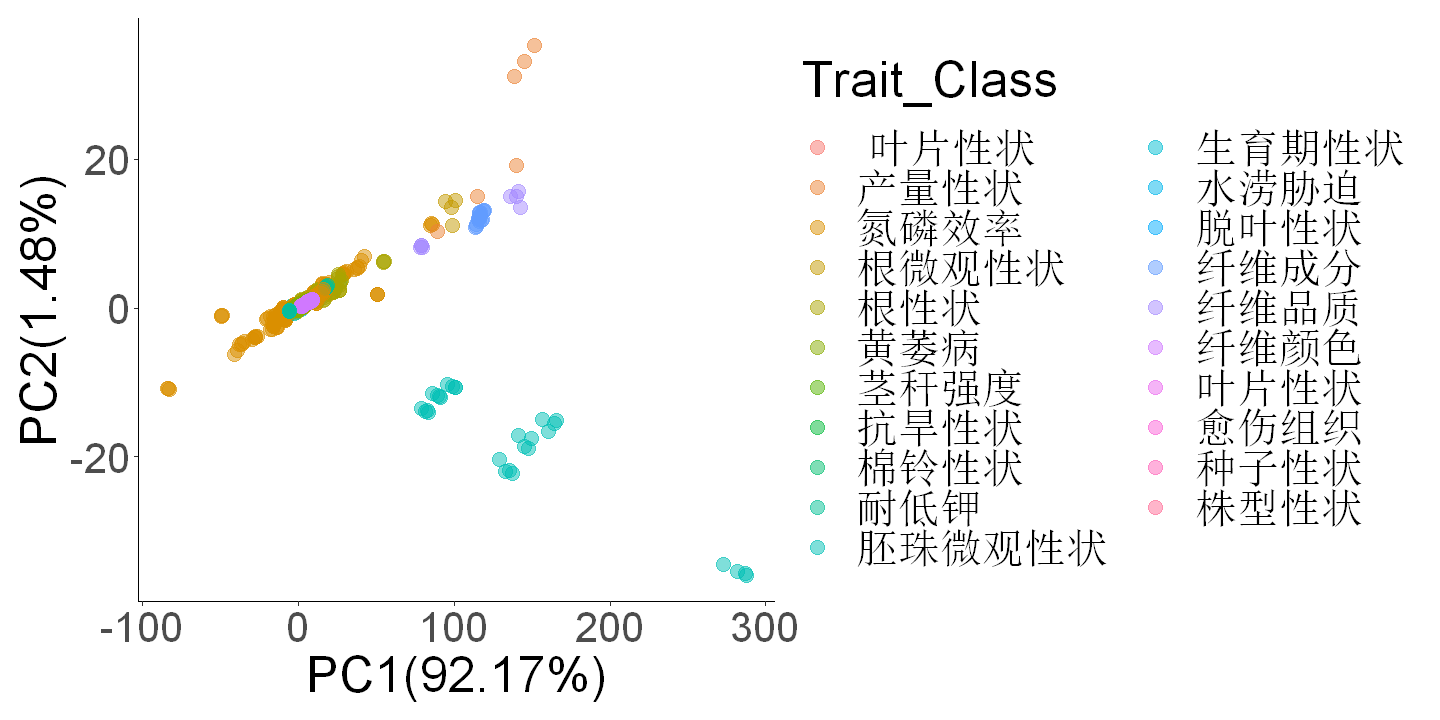

In [410]:
pca_df <- as.data.frame(pca_1$x)
summ <- summary(pca_1)
xlab <- paste0("PC1(", round(summ$importance[2, 1] * 100, 2), "%)")
ylab <- paste0("PC2(", round(summ$importance[2, 2] * 100, 2), "%)")

options(repr.plot.width = 12, repr.plot.height = 6)

pca_df %>% 
    rownames_to_column("Trait_ID") %>% 
    merge(df_raw_anno[c(1, 3)] %>% setNames(c('Trait_ID', 'Trait_Class'))) %>% 
    subset(!(Trait_ID %in% rownames(df_label))) %>% 
    ggplot(., aes(x = PC1,y = PC2, color = Trait_Class))+
    geom_point(alpha = 0.5, size = 4)+
#     geom_text_repel(data = df_label, 
#                       max.overlaps = 20,
#                       aes(PC1, PC2, label=rownames(df_label)),
#                       size = 4)+
    labs(x = xlab,y = ylab)+
    guides(fill = "none")+
    theme_classic()+
    theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 25),
        axis.title = element_text(size = 30),
        legend.text = element_text(size = 25),
        legend.title = element_text(size = 30),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

##### 源库流

###### 碳

In [66]:
# PCA code
pca_1 <- df_ykl %>% 
    remove_rownames() %>% 
    column_to_rownames('ID') %>%
    sapply(., as.numeric) %>%
    t() %>% 
    imputePCA(., scale = F, method = "Regularized") %>% 
    .$completeObs %>% 
    prcomp(., center = T, scale. = T)

Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"
Warning message in lapply(X = X, FUN = FUN, ...):
"NAs introduced by coercion"


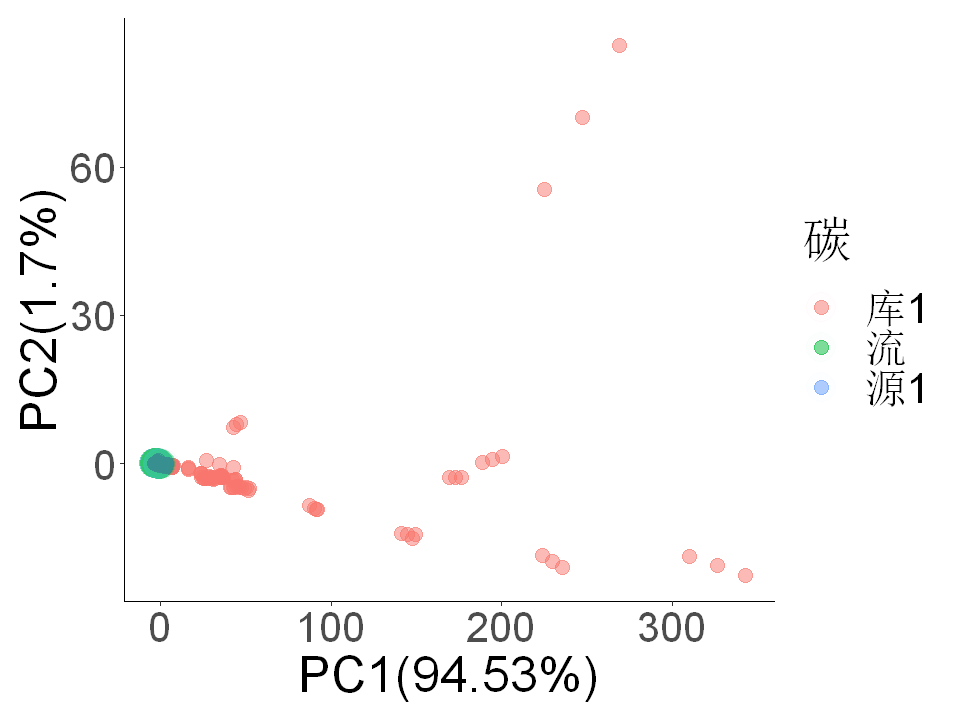

In [67]:
# plot
pca_df <- as.data.frame(pca_1$x)
summ <- summary(pca_1)
xlab <- paste0("PC1(", round(summ$importance[2, 1] * 100, 2), "%)")
ylab <- paste0("PC2(", round(summ$importance[2, 2] * 100, 2), "%)")

options(repr.plot.width = 8, repr.plot.height = 6)

pca_df %>% 
    rownames_to_column("Trait_ID") %>% 
    merge(df_ykl_anno[c(1, 4)] %>% setNames(c('Trait_ID', '碳')), by = 'Trait_ID', all.x = T) %>% 
    ggplot(., aes(x = PC1,y = PC2, color = 碳))+
    geom_point(alpha = 0.5, size = 4)+
    geom_point(data = . %>% subset(碳 != '库1'), size = 8, alpha = 0.01) +
    labs(x = xlab,y = ylab)+
    guides(fill = "none")+
    theme_classic()+
    theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 25),
        axis.title = element_text(size = 30),
        legend.text = element_text(size = 25),
        legend.title = element_text(size = 30),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

###### 无机氮

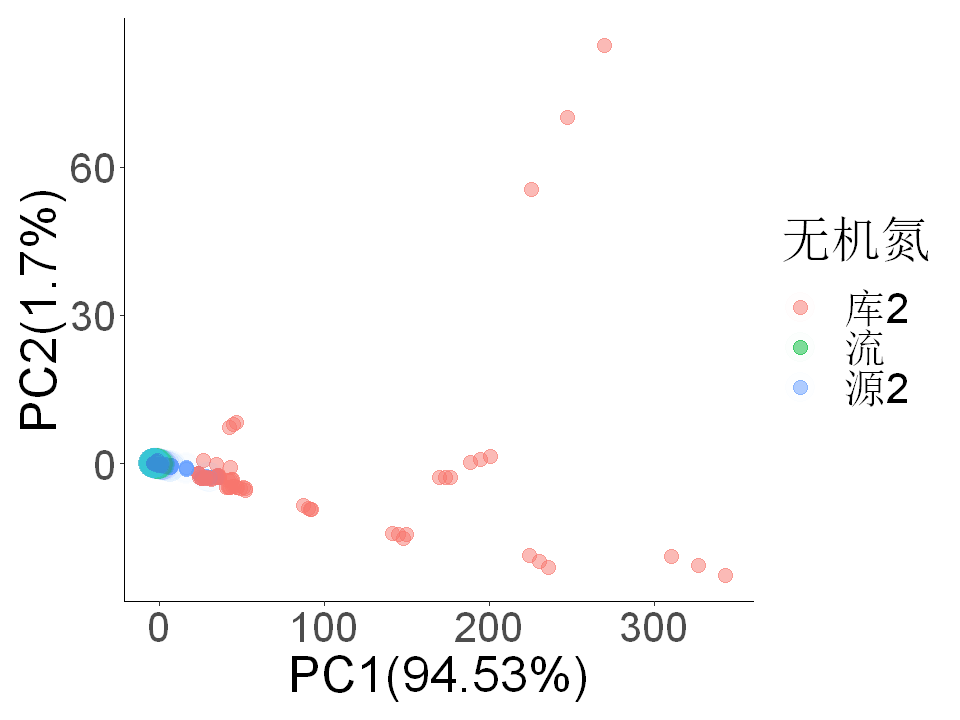

In [68]:
# PCA 
options(repr.plot.width = 8, repr.plot.height = 6)

pca_df %>% 
    rownames_to_column("Trait_ID") %>% 
    merge(df_ykl_anno[c(1, 5)] %>% setNames(c('Trait_ID', '无机氮')), by = 'Trait_ID', all.x = T) %>% 
    ggplot(., aes(x = PC1,y = PC2, color = 无机氮))+
    geom_point(alpha = 0.5, size = 4)+
    geom_point(data = . %>% subset(无机氮 != '库2'), size = 8, alpha = 0.01) +
    labs(x = xlab,y = ylab)+
    guides(fill = "none")+
    theme_classic()+
    theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 25),
        axis.title = element_text(size = 30),
        legend.text = element_text(size = 25),
        legend.title = element_text(size = 30),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

###### 有机氮

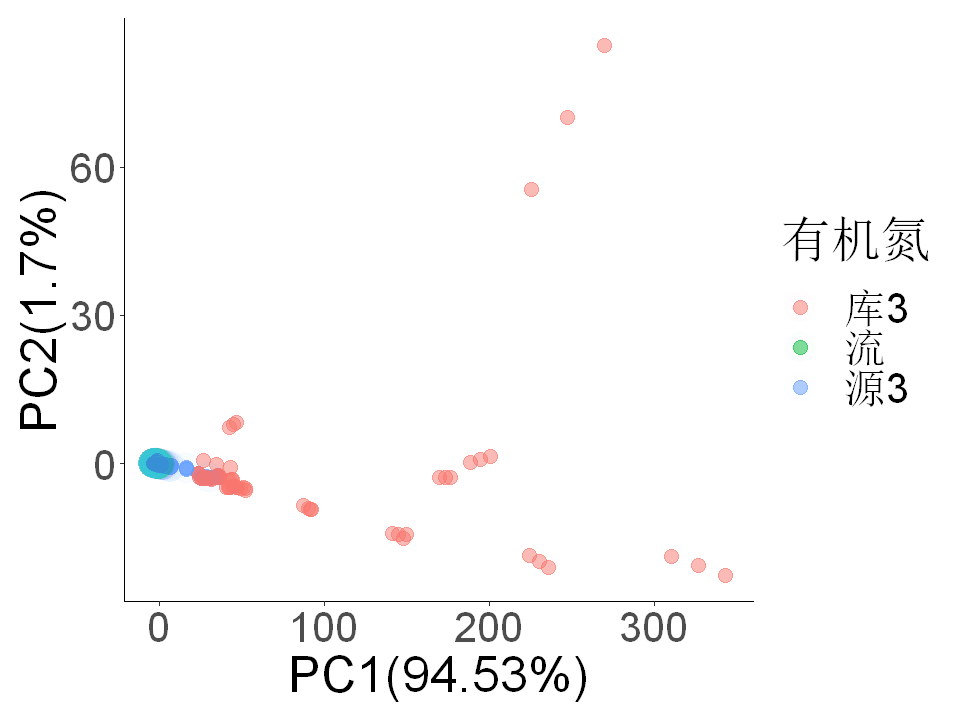

In [69]:
# PCA
options(repr.plot.width = 8, repr.plot.height = 6)

pca_df %>% 
    rownames_to_column("Trait_ID") %>% 
    merge(df_ykl_anno[c(1, 6)] %>% setNames(c('Trait_ID', '有机氮')), by = 'Trait_ID', all.x = T) %>% 
    ggplot(., aes(x = PC1,y = PC2, color = 有机氮))+
    geom_point(alpha = 0.5, size = 4)+
    geom_point(data = . %>% subset(有机氮 != '库3'), size = 8, alpha = 0.01) +
    labs(x = xlab,y = ylab)+
    guides(fill = "none")+
    theme_classic()+
    theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 25),
        axis.title = element_text(size = 30),
        legend.text = element_text(size = 25),
        legend.title = element_text(size = 30),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

#### 抗逆-抗病性状

In [432]:
# PCA code
pca_1 <- df_stress %>% 
    remove_rownames() %>% 
    column_to_rownames('ID') %>%
    sapply(., as.numeric) %>%
    t() %>% 
    imputePCA(., scale = F, method = "Regularized") %>% 
    .$completeObs %>% 
    prcomp(., center = T, scale. = T)

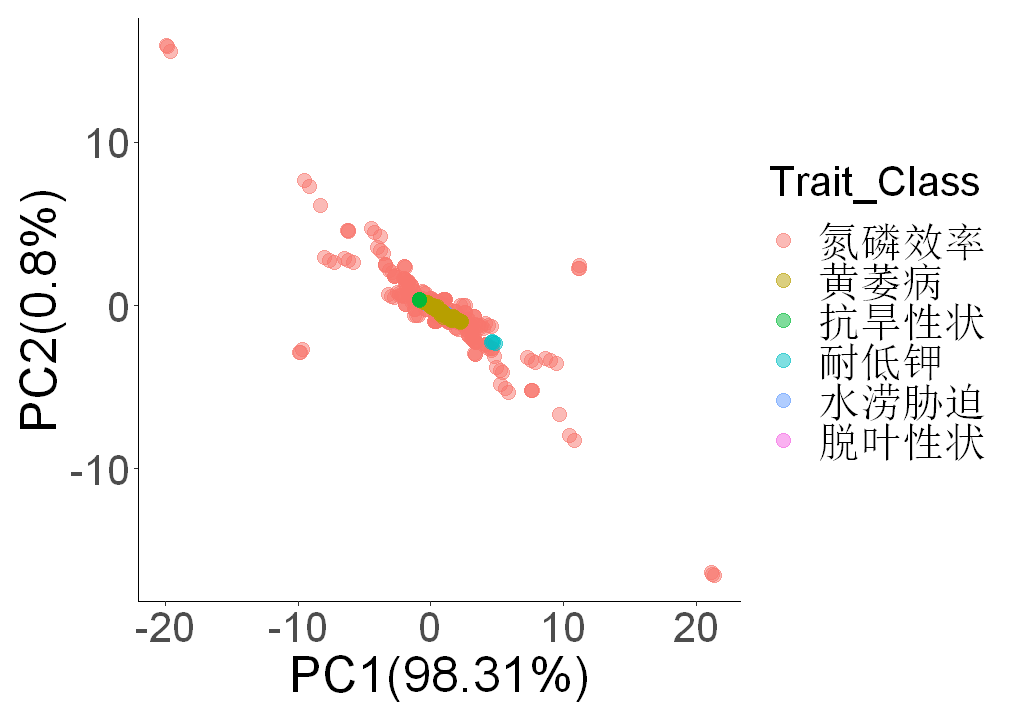

In [437]:
# plot
pca_df <- as.data.frame(pca_1$x)
summ <- summary(pca_1)
xlab <- paste0("PC1(", round(summ$importance[2, 1] * 100, 2), "%)")
ylab <- paste0("PC2(", round(summ$importance[2, 2] * 100, 2), "%)")

options(repr.plot.width = 8.5, repr.plot.height = 6)

pca_df %>% 
    rownames_to_column("Trait_ID") %>% 
    merge(df_raw_anno[c(1, 3)] %>% setNames(c('Trait_ID', 'Trait_Class'))) %>% 
    subset(!(Trait_ID %in% rownames(df_label))) %>% 
    ggplot(., aes(x = PC1,y = PC2, color = Trait_Class))+
    geom_point(alpha = 0.5, size = 4)+
    labs(x = xlab,y = ylab)+
    guides(fill = "none")+
    theme_classic()+
    theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 25),
        axis.title = element_text(size = 30),
        legend.text = element_text(size = 25),
        legend.title = element_text(size = 25),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

### 遗传力

### 遗传相关

### Genotype PCA

In [16]:
geno_pca <- read.csv("../02.DNNGP/Allchr.snp.final.plink_out.PCA.eigenvec", sep = " ", header = F)
geno_eigenval <- read.csv("../02.DNNGP/Allchr.snp.final.plink_out.PCA.eigenval", header=F)

In [22]:
PC1_contri = geno_eigenval$V1[1] / sum(geno_eigenval$V1) * 100
PC1_contri
PC2_contri = geno_eigenval$V1[2] / sum(geno_eigenval$V1) * 100
PC2_contri

[1] 9.62693

[1] 7.482119

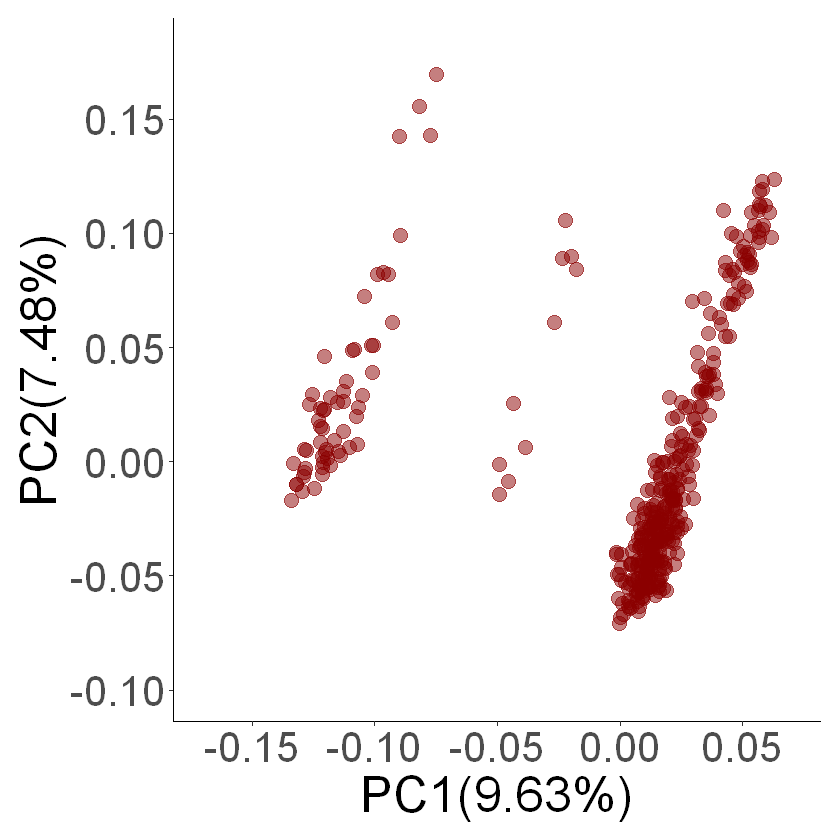

In [35]:
xlab <- paste0("PC1(", round(PC1_contri, 2), "%)")
ylab <- paste0("PC2(", round(PC2_contri, 2), "%)")

geno_pca[c('V2', 'V3', 'V4')] %>% 
    ggplot(., aes(x = V3,y = V4))+
        geom_point(alpha = 0.5, size = 4, color = 'darkred')+
        labs(x = xlab,y = ylab)+
        scale_y_continuous(limits = c(-0.1, 0.18), n.breaks = 6) +
        scale_x_continuous(limits = c(-0.17, 0.07), n.breaks = 6) +
        guides(fill = "none")+
        theme_classic()+
        theme(plot.title = element_text(hjust = 0.5,size = 15),
            axis.text = element_text(size = 25),
            axis.title = element_text(size = 30),
            legend.text = element_text(size = 25),
            legend.title = element_text(size = 25),
            plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

### Genomic Prediction Idea

In [2]:
GP_result <- data.frame(method = c("GBLUP", "DNNGP"), Accuracy = c(0.561051594498058, 0.6570304547394623))

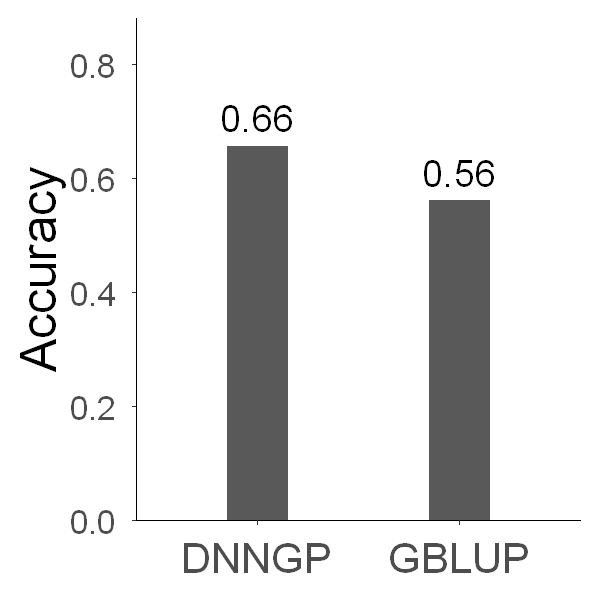

In [12]:
options(repr.plot.width = 5, repr.plot.height = 5)

GP_result %>% 
ggplot(aes(method, Accuracy)) +
    geom_col(width = 0.3) +
    geom_text(data = GP_result, aes(method, Accuracy + 0.05, label= round(Accuracy, 2)), size = 8) +
    scale_y_continuous(limits = c(0, 0.8), expand = expansion(mult = c(0, 0.1)))+
    theme_classic()+    
    theme(axis.text.y = element_text(size = 20, margin = margin(t = , r = 10, b = 0, l = 0)),
          axis.text.x = element_text(size = 25, angle = 0, margin = margin(t = 10, r = 0, b = 0, l = 0)),
          axis.title = element_text(size = 30),
          axis.title.x  = element_blank(),
          legend.text = element_text(size = 25),
          legend.title = element_text(size = 30),
          plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))

### WJX PCA script

In [16]:
new_df <- read.csv("../WJX_PCA_script/Weather_data.csv", row.names = 1)
pca <- prcomp(new_df, center = T, scale. = T)
pca_df <- as.data.frame(pca$x)
summ <- summary(pca)
xlab <- paste0("PC1(", round(summ$importance[2, 1] * 100, 2), "%)")
ylab <- paste0("PC2(", round(summ$importance[2, 2] * 100, 2), "%)")

In [17]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
肇东,-55.19550,-30.347561,-0.8693720,16.4813604,-3.1363093,3.88805289,-4.4295436,3.911746,-10.69746654,21.1043378,⋯,0.2917916,0.8765058,2.33720348,-0.43539741,-1.2292899,-2.10171554,-1.3511553,1.2276362,0.22215545,-1.268668e-14
双城,-54.62124,-29.748070,-7.5146545,13.1471410,-1.2436508,-6.19343148,0.2962964,-13.880940,7.52986552,3.5760926,⋯,-1.6945694,-4.3936931,-7.00613377,1.53633648,-1.6424848,0.51128842,1.8669671,0.7126664,-0.31641111,1.405679e-14
赵县,27.26685,5.898197,0.4267542,9.9115865,16.3153576,14.35525143,3.1551775,-7.216661,-5.59369304,-2.9081090,⋯,-3.8800422,-1.7902161,-0.09391519,2.29834976,-8.3155389,3.00371456,-0.5148009,3.1437437,-0.58158338,2.422606e-14
任县,36.21852,5.002966,5.2814985,15.7574595,18.0845488,7.28123840,5.7547428,-4.262377,-9.58736920,-7.5321895,⋯,-0.9313229,1.8007336,-6.18271492,-5.90400290,1.2643736,0.28007136,1.3915017,-2.5559370,0.86504661,1.484837e-14
安阳,33.12639,6.160870,19.4408232,11.0301848,-2.4925835,11.19902803,9.5569663,-16.047095,7.98496308,3.0582254,⋯,9.1861239,-4.0184072,-0.89566959,2.17075988,5.2941414,-3.42070127,-4.1384826,1.1400779,1.80074613,1.748325e-14
博爱,44.61932,4.563534,-32.4628331,3.3776005,-16.3817988,7.32849742,15.1415418,9.071671,14.68833291,15.1977098,⋯,0.7775123,0.9019836,-3.70985722,3.23513596,-1.1689491,0.55783552,0.5886934,-0.6060925,0.17284742,1.698240e-14
新乡,39.90042,6.819283,11.3094491,4.4602289,-2.2640305,2.94962674,10.5262021,-3.428803,4.29242661,3.2128578,⋯,-11.0077159,-2.2320580,3.77943562,-1.58495673,-2.9557063,-0.85009499,8.7494294,1.5501614,-1.77154841,2.515219e-14
鹤壁,29.47160,7.569578,25.0823205,32.5935353,-32.9845822,5.24886651,-9.4635701,18.111073,5.65023576,-14.7499425,⋯,-0.8453954,0.6769086,-1.00069771,0.62973303,0.1929588,-0.34788418,-0.1299884,-0.2244095,-0.57713710,-7.857430e-15
成安,26.98560,10.392942,30.1890999,2.0677918,15.2850520,18.12040340,1.8433457,4.462342,-8.06977300,9.5942537,⋯,-0.9149608,0.4342661,0.26800877,1.06399358,0.7553188,0.02286055,-0.5664743,0.1187486,-0.90952288,2.057111e-14


In [15]:
provin = read.csv("../WJX_PCA_script/Province.csv")
provin

省份,站点
<chr>,<chr>
黑龙江,肇东
黑龙江,双城
河北,赵县
河北,任县
河南,安阳
河南,博爱
河南,新乡
河南,鹤壁
河北,成安


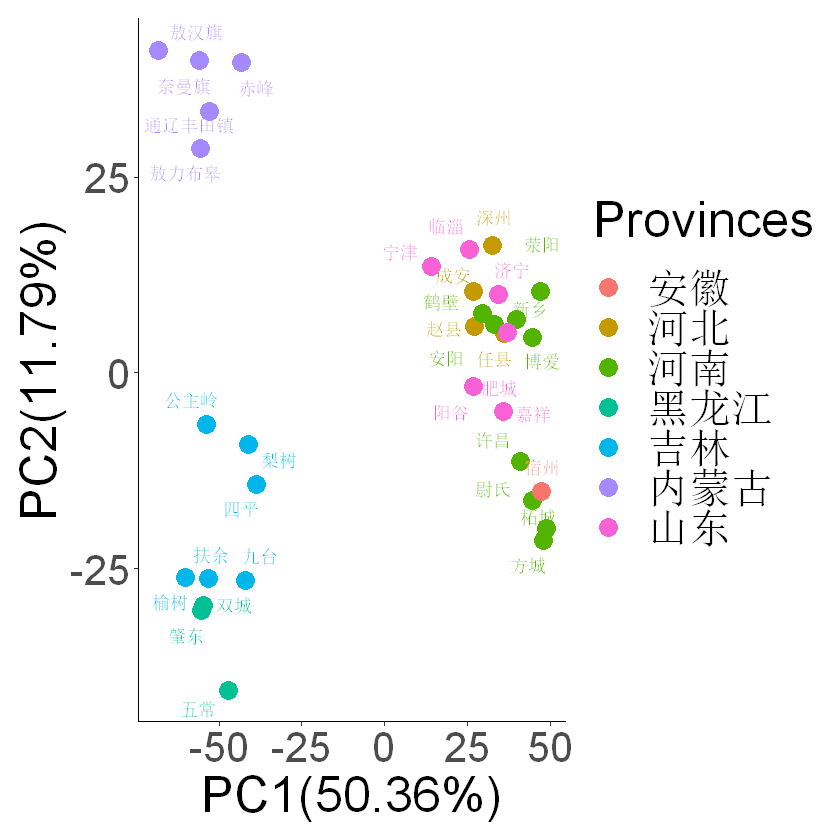

In [9]:
provin = read.csv("../WJX_PCA_script/Province.csv")

p.pca <- ggplot(data = pca_df,aes(x = PC1,y = PC2,color = provin$省份))+
  # stat_ellipse(aes(fill = provin$省份),
  # type = "norm",geom = "polygon",alpha = 0.25,color = NA)+ # 添加置信椭圆
  geom_point(size = 5)+
  # scale_shape_manual(values = c(0:25,33:38,42,45))+ #改变形状
  labs(x = xlab,y = ylab,color = "Provinces",shape = "Provinces")+
  guides(fill = "none")+
  theme_classic()+
  theme(plot.title = element_text(hjust = 0.5,size = 15),
        axis.text = element_text(size = 25),
        axis.title = element_text(size = 30),
        legend.text = element_text(size = 25),
        legend.title = element_text(size = 30),
        plot.margin = unit(c(0.4,0.4,0.4,0.4),'cm'))+
  geom_text_repel(data = pca_df, aes(x = PC1,y = PC2, label = rownames(pca_df)),
#                   family = "STHeiti", 
                  max.overlaps = 50,
                  force = 10,
                  arrow = arrow(length = unit(0.1,"cm"),
                                type = "open",
                                ends = "last"),
                  point.padding = 10,
                  segment.color = "grey20",
                  segment.size=0.5,
                  segment.alpha = 0.8)
p.pca